In [2]:
import pandas as pd
df = pd.read_csv('~/Desktop/UCD/spring_2025/ecs_111/final_project/creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
# Time: Number of seconds elapsed between this transaction and the first transaction in the dataset
# V1 ~ V28: may be result of a PCA Dimensionality reduction to protect user identities and sensitive features(v1-v28)
# Amount: the transaction amount 
# Class : 1 in case of fraud, 0 otherwise

In [4]:
df['Class'].value_counts(normalize = True) # imbalanced dataset

0    0.998273
1    0.001727
Name: Class, dtype: float64

In [5]:
# Since V1 ~ V28 columns are results of a PCA dimensionality reduction, we don't need to do any preprocessing
# Feature scaling column "Amount" and "Time"

from sklearn.preprocessing import StandardScaler
df['scaled_amount'] = StandardScaler().fit_transform(df['Amount'].values.reshape(-1, 1))
df['scaled_time'] = StandardScaler().fit_transform(df['Time'].values.reshape(-1, 1))

df.drop(['Time', 'Amount'], axis = 1, inplace = True)

In [6]:
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

X = df.drop('Class', axis = 1)
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 2025, stratify = y)

# Applying SMOTE (oversampling)
smote = SMOTE(random_state = 2025)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

rf = RandomForestClassifier(random_state = 2025)
rf.fit(X_train_resampled, y_train_resampled)

y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.87      0.84      0.85        98

    accuracy                           1.00     56962
   macro avg       0.94      0.92      0.93     56962
weighted avg       1.00      1.00      1.00     56962



# Random Forest output
- Recall = 0.84 -> correctly finds 84% of true fraud action
- Precision = 0.87 -> 87% of our y_pred were actual fraud action
- F1-score = 0.85 -> output is well-balanced
- Since accuracy of 1 is too high, looking at recall / precision will be more trustworthy

In [7]:
from xgboost import XGBClassifier

xgb = XGBClassifier(use_label_encoder = False, eval_metric = 'logloss', random_state = 2025)
xgb.fit(X_train_resampled, y_train_resampled)
y_pred_xgb = xgb.predict(X_test)
xgb_report = classification_report(y_test, y_pred_xgb)
print(xgb_report)

/Users/gyeongseoblee/.local/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [01:37:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.79      0.84      0.81        98

    accuracy                           1.00     56962
   macro avg       0.89      0.92      0.91     56962
weighted avg       1.00      1.00      1.00     56962



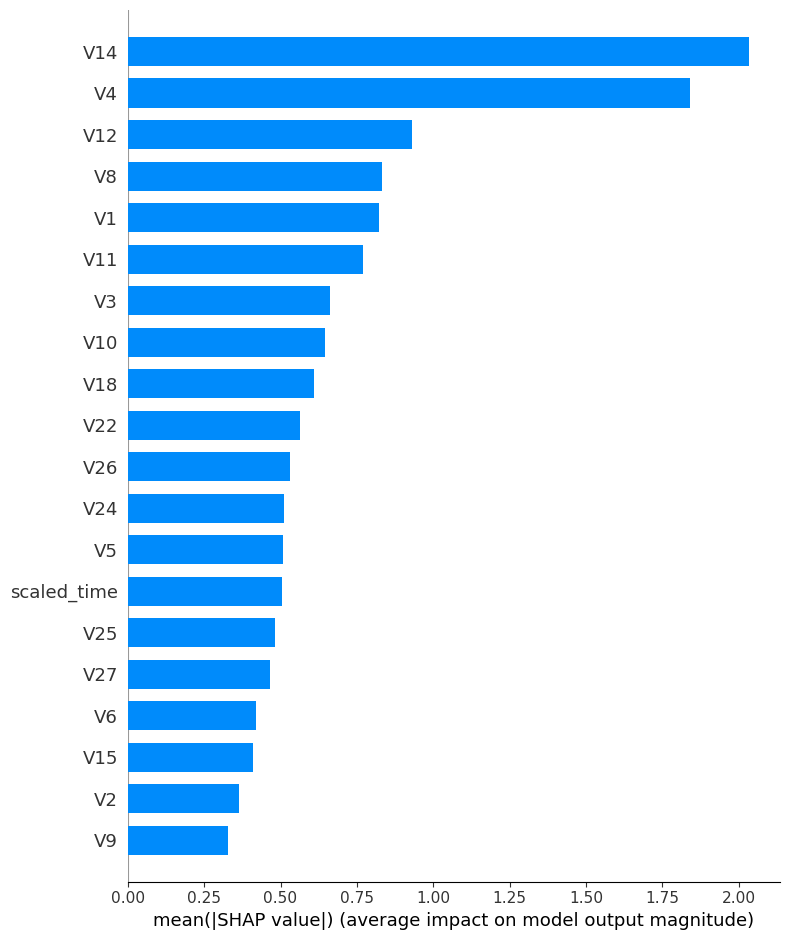

In [8]:
import shap

explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, plot_type = 'bar')

# XGBoost output
- Recall = 0.84 -> correctly finds 84% of true fraud action
- Precision = 0.79 -> 79% of our y_pred were actual fraud action
- F1-score = 0.81 -> output is well-balanced

In [9]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes = (64, 32) , max_iter = 100, random_state = 2025)
mlp.fit(X_train_resampled, y_train_resampled)
y_pred_mlp = mlp.predict(X_test)
mlp_report = classification_report(y_test, y_pred_mlp)
print(mlp_report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.66      0.82      0.73        98

    accuracy                           1.00     56962
   macro avg       0.83      0.91      0.87     56962
weighted avg       1.00      1.00      1.00     56962



# Multi-Layer Perceptron output
- Recall = 0.82 -> correctly finds 82% of true fraud action
- Precision = 0.66 -> 66% of our y_pred were actual fraud action
- F1-score = 0.73